In [1]:
# import all required packages
%matplotlib inline
import requests
from html.parser import HTMLParser
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import datetime
import re 
import time
import pandas as pd
from math import ceil
import os
import matplotlib.pyplot as plt

from itertools import cycle
import traceback

import math

def parse_transactions(long_string: pd.DataFrame):
    k = long_string.split('[')
    kk = k[1].split(']')
    kkk = kk[0].replace("'", '"')  
    splt_char = ','
    K = 3
    temp = kkk.split(splt_char) 
    #res = splt_char.join(temp[:K]), splt_char.join(temp[K:]) 

    parsed = []
    for i,j in enumerate(temp):
        if i % 3 == 0:
            parsed.append(f'({temp[i]},{temp[i+1]},{temp[i+2]}')

    full_parsed = []
    for i in parsed:
        try:
            full_parsed.append(json.loads(i.strip('(')))
        except:
            print(i)
    
    return full_parsed
    #full_parsed = [json.loads(i).strip('(') for i in parsed]

def get_week_of_transaction(release_date: datetime, transaction_date: datetime) -> int: 
    number_of_days = transaction_date - release_date
    week = math.floor(int(number_of_days.days) / 7)
    
    return week

In [62]:
adi_df = pd.read_csv('./persistence/adidas.csv')
adi_df['transactionHistory'] = adi_df['transactionHistory'].apply(lambda x: parse_transactions(x))
jord_df = pd.read_csv('./persistence/jordans.csv')
jord_df['transactionHistory'] = jord_df['transactionHistory'].apply(lambda x: parse_transactions(x))
nikes_df = pd.read_csv('./persistence/nikes.csv')
nikes_df['transactionHistory'] = nikes_df['transactionHistory'].apply(lambda x: parse_transactions(x))

In [63]:
df = pd.concat([adi_df, nikes_df, jord_df], ignore_index=True, sort = False)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 11 columns):
color                 2859 non-null object
model                 2859 non-null object
itemCondition         2859 non-null object
name                  2859 non-null object
brand                 2859 non-null object
releaseDate           2859 non-null object
sku                   2859 non-null object
image                 2859 non-null object
url                   2859 non-null object
retailPrice($)        2846 non-null object
transactionHistory    2859 non-null object
dtypes: object(11)
memory usage: 245.8+ KB


In [65]:
#  changing retail price to float
df['retailPrice($)'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df['retailPrice($)'] = pd.to_numeric(df['retailPrice($)'])

In [6]:
skus_and_retail_price = df[['sku', 'retailPrice($)','transactionHistory', 'releaseDate']]

In [7]:
new_dfs = []
for row in skus_and_retail_price.iterrows():
    temp = pd.DataFrame(row[1]['transactionHistory'])
    temp['sku'] = row[1]['sku']
    temp['retailPrice($)'] = row[1]['retailPrice($)']
    temp['releaseDate'] = row[1]['releaseDate']
    new_dfs.append(temp)
    
fat_df = pd.concat(new_dfs, ignore_index=True, sort = False)
fat_df['createdAt'] = fat_df['createdAt'].str.split('T').str[0]
fat_df['createdAt'] =  pd.to_datetime(fat_df['createdAt'])
fat_df['releaseDate'] =  pd.to_datetime(fat_df['releaseDate'])

In [8]:
fat_df.count()

amount            5856828
createdAt         5856828
shoeSize          5856828
sku               5856828
retailPrice($)    5780145
releaseDate       5856828
dtype: int64

In [9]:
fat_df['weekOfTransaction'] = fat_df.apply(lambda x: get_week_of_transaction(x['releaseDate'], x['createdAt']), axis=1)  # TAKES VERY LONG!!!

In [10]:
#  Calculating profit made on each transaction
fat_df['Profit(%)'] = round((fat_df['amount']-fat_df['retailPrice($)'])/fat_df['retailPrice($)']*100, 2)
fat_df['Profit($)']= fat_df['amount']-fat_df['retailPrice($)']

#  Calculating the average transaction for each week for each shoe
profit_per_week_df = fat_df[['sku','weekOfTransaction','Profit(%)']].groupby(['sku','weekOfTransaction']).mean().reset_index()
profit_per_week_df_pivoted = profit_per_week_df.pivot('sku', 'weekOfTransaction', 'Profit(%)').reset_index()

#  selecting only the first 3 years after release date of a shoe (weeks 0-155)
profit_per_week_df_pivoted = profit_per_week_df_pivoted[['sku', *list(range(0,156))]]

# making a dict for renaming columns
# orig_cols = profit_per_week_df_pivoted.columns[1:]
# renaming_dict = {orig_col: f'week_of_transaction_{orig_col}' for orig_col in orig_cols}
# profit_per_week_df_pivoted.rename(columns=renaming_dict, inplace=True)

profit_per_week_df_pivoted.head()

weekOfTransaction,sku,0,1,2,3,4,5,6,7,8,...,146,147,148,149,150,151,152,153,154,155
0,001e7934-9322-4562-bd3e-b6e57ffa8e36,22.150270,9.929783,9.005667,6.042903,12.305000,15.096000,18.042917,23.403333,12.567308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,002f1c70-7afe-4d30-b335-5a5ffca8bb42,51.496829,40.022800,41.352000,43.563333,48.399231,29.278333,43.581250,35.678000,39.053750,...,88.352619,91.080952,78.333611,102.02359,84.192075,100.464722,82.267826,90.492941,98.348889,86.1402
2,00337faf-4cd3-4b21-a2f8-c24ee74a768f,-19.481111,-29.732000,-32.466000,-37.276667,NaN,-25.000000,-38.094286,-41.734000,-33.330000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00452891-341f-43df-a0e2-6164a18a3ed8,16.110000,0.000000,-34.725000,5.560000,-38.117692,-36.267500,-26.220000,-38.885000,-28.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00945770-349a-44fc-8ac9-35102c8b3488,253.100065,188.213356,152.215824,146.727368,126.054104,118.436825,90.933034,82.491892,87.204630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#  drop retail price because it messes up things later on
fat_df = fat_df.drop(['retailPrice($)'], axis=1)
fat_df.head()

,amount,createdAt,shoeSize,sku,releaseDate,weekOfTransaction,Profit(%),Profit($)
0,320.0,2020-01-18,7,4a33ef38-2497-4229-8b28-c2fea95cc17c,2019-12-20,4,45.45,100.0
1,270.0,2020-01-18,10,4a33ef38-2497-4229-8b28-c2fea95cc17c,2019-12-20,4,22.73,50.0
2,268.0,2020-01-18,9,4a33ef38-2497-4229-8b28-c2fea95cc17c,2019-12-20,4,21.82,48.0
3,290.0,2020-01-18,13,4a33ef38-2497-4229-8b28-c2fea95cc17c,2019-12-20,4,31.82,70.0
4,300.0,2020-01-18,7.5,4a33ef38-2497-4229-8b28-c2fea95cc17c,2019-12-20,4,36.36,80.0


### Analysing total count and profit for different sneaker shoe sizes

**NOTE: SOME SHOE SIZES HAVE LETTERS IN THEM LIKE W (WOMEN) AND Y (YOUTH), FOR EASINESS AND BECAUSE THEY AREN'T COMMON WE WILL ELIMINATE THOSE FROM OUR CALCULATIONS**

In [13]:
import re
#  deleting all rows where shoeSize has a letter
fat_df_shoe_size_no_letters = fat_df[~fat_df['shoeSize'].str.contains('[a-zA-Z]')]

In [14]:
#  Total number of different shoe sizes 
len(fat_df_shoe_size_no_letters['shoeSize'].unique())

33

In [15]:
#  Calculating total counts and average profit for each shoe size
grouped_by_shoe_size_count = fat_df_shoe_size_no_letters.groupby(['shoeSize'])['amount'].count()
grouped_by_shoe_size_count = grouped_by_shoe_size_count.rename('Count')  # renaming
grouped_by_shoe_size_profit_mean = fat_df_shoe_size_no_letters.groupby(['shoeSize'])['Profit(%)'].mean()

In [16]:
#  Normalising total counts and profit dfs into precentages so I can plot on same graph
normalised_grouped_by_shoe_size_count = (grouped_by_shoe_size_count / grouped_by_shoe_size_count.sum()).sort_values(ascending=False)
normalised_grouped_by_shoe_size_profit_mean = (grouped_by_shoe_size_profit_mean / grouped_by_shoe_size_profit_mean.sum()).sort_values(ascending=False)

In [17]:
#  Turning into dfs and merging so that I can plot double bar chart
df_grouped_by_shoe_size_count = normalised_grouped_by_shoe_size_count.to_frame().reset_index().rename(columns={"index": "shoeSize"})
df_grouped_by_shoe_size_profit_mean = normalised_grouped_by_shoe_size_profit_mean.to_frame().reset_index().rename(columns={"index": "shoeSize"})

df_shoe_size_profit_and_count = pd.merge(df_grouped_by_shoe_size_count, df_grouped_by_shoe_size_profit_mean, on='shoeSize')
df_shoe_size_profit_and_count.head(10)

,shoeSize,Count,Profit(%)
0,10,0.117928,0.030432
1,9.5,0.105044,0.032082
2,10.5,0.104966,0.026449
3,11,0.103173,0.027719
4,9,0.099684,0.034452
5,12,0.077453,0.026115
6,8.5,0.072385,0.034758
7,8,0.066643,0.036915
8,11.5,0.050354,0.024675
9,13,0.049678,0.025093


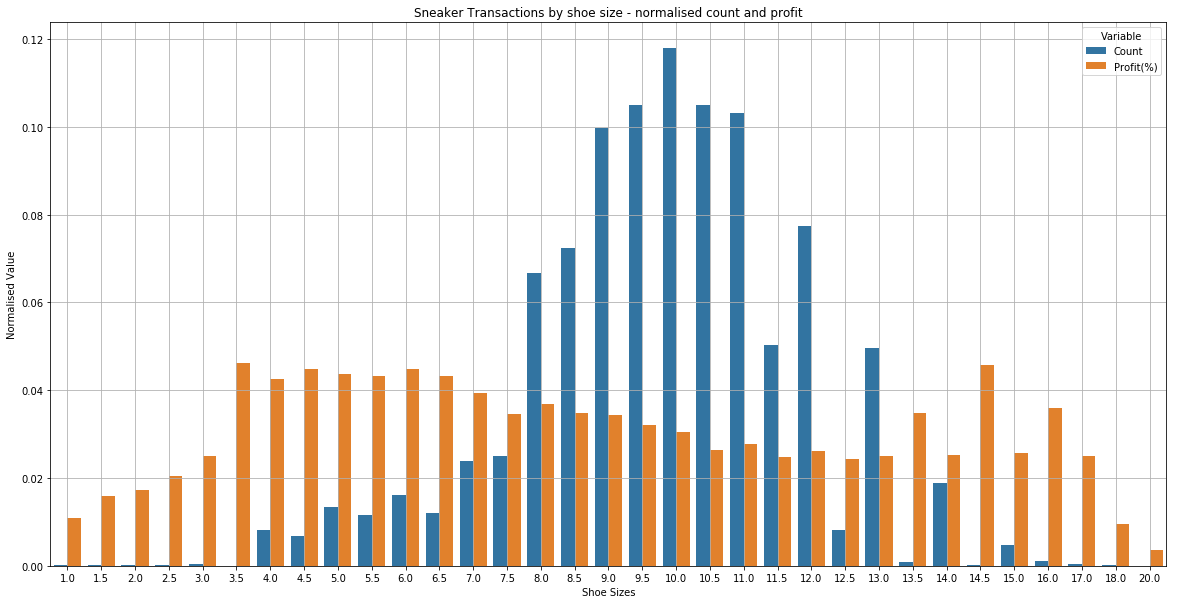

In [18]:
#  melting so that we can nicely plot with seaborn
df_shoe_size_profit_and_count_melted = df_shoe_size_profit_and_count.melt(id_vars='shoeSize').rename(columns=str.title)
df_shoe_size_profit_and_count_melted = df_shoe_size_profit_and_count_melted.sort_values(by=['Shoesize'])
df_shoe_size_profit_and_count_melted['Shoesize'] = pd.to_numeric(df_shoe_size_profit_and_count_melted['Shoesize'])

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Shoesize', y='Value', hue='Variable', data=df_shoe_size_profit_and_count_melted, ax=ax1)
ax1.set_ylabel('Normalised Value')
ax1.set_xlabel('Shoe Sizes')
ax1.set_title('Sneaker Transactions by shoe size - normalised count and profit')
plt.grid()

In [19]:
#  So that I don't get weird columns in the next cell
fat_df_for_use = fat_df.drop(['Profit(%)'], axis=1)
fat_df_for_use = fat_df_for_use.drop(['Profit($)'], axis=1)
fat_df_for_use = fat_df_for_use.drop(['weekOfTransaction'], axis=1)
fat_df_for_use = fat_df_for_use.drop(['releaseDate'], axis=1)

In [59]:
fat_df_for_use = fat_df_for_use.drop(['retailPrice($)'], axis=1)

In [60]:
fat_df_for_use.head()

,amount,createdAt,shoeSize,sku
0,320.0,2020-01-18,7,4a33ef38-2497-4229-8b28-c2fea95cc17c
1,270.0,2020-01-18,10,4a33ef38-2497-4229-8b28-c2fea95cc17c
2,268.0,2020-01-18,9,4a33ef38-2497-4229-8b28-c2fea95cc17c
3,290.0,2020-01-18,13,4a33ef38-2497-4229-8b28-c2fea95cc17c
4,300.0,2020-01-18,7.5,4a33ef38-2497-4229-8b28-c2fea95cc17c


### Concatenating all brand dfs together and adding insights from total transactions 

In [67]:
#  calculating average transaction for each shoe
df = pd.merge(df, fat_df_for_use.groupby(['sku']).mean(), on='sku', how='outer')
df = df.rename(columns={"amount":"averageTransaction"})


In [69]:
#   calculating total transaction for each shoe
df = pd.merge(df, fat_df_for_use.groupby(['sku']).count(), on='sku', how='outer')  # change aggregate functions here
df = df.drop(['createdAt', 'shoeSize'], axis=1)
df = df.rename(columns={"amount":"totalTransactions"})

**Whenever a graph falls on a normal distribution, using the mean is a good choice. But if your data has extreme scores (such as the difference between a millionaire and someone making 30,000 a year), you will need to look at median, because you’ll find a much more representative number for your sample.**

In [71]:
df = pd.merge(df, fat_df_for_use.groupby(['sku']).median(), on='sku', how='outer')  # change aggregate functions here
df = df.rename(columns={"amount":"medianTransaction"})

In [73]:
#  calculating average profit/loss from retail price for each shoe
df['averagePremiumPrice(%)'] = round((df['averageTransaction']-df['retailPrice($)'])/df['retailPrice($)']*100, 2)
df['medianProfit'] = df['medianTransaction'] - df['retailPrice($)']
df['medianPremiumPrice(%)'] = round((df['medianTransaction']-df['retailPrice($)'])/df['retailPrice($)']*100, 2)

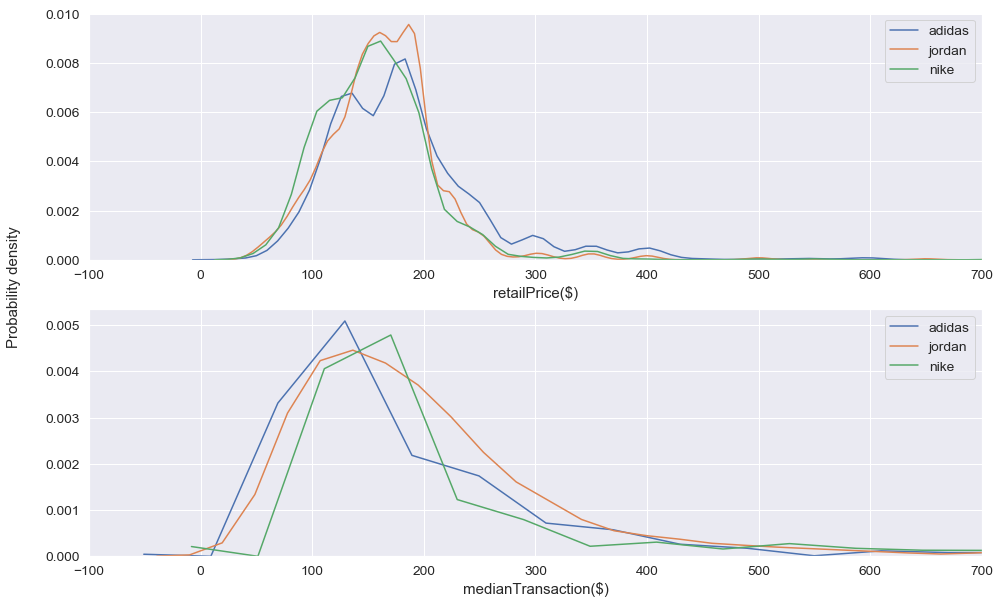

In [75]:
#  going to create distributions of retail price with average transaction price on top of each other for each brand
# Sort the dataframe by target
df_no_na = df.dropna()
adi_chunk = df_no_na.loc[df_no_na['brand'] == 'adidas']
jord_chunk = df_no_na.loc[df_no_na['brand'] == 'Jordan']
nike_chunk = df_no_na.loc[df_no_na['brand'] == 'Nike']

# Creating a figure with subplots 
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,10))
sns.set_style('dark')
plt.grid()
sns.set(font_scale = 1.25)

#ax1 = fig.add_subplot(1, 1, 1)
sns.distplot(adi_chunk[['retailPrice($)']], hist=False, label='adidas', ax = ax1)
sns.distplot(jord_chunk[['retailPrice($)']], hist=False, label='jordan', ax = ax1)
sns.distplot(nike_chunk[['retailPrice($)']], hist=False, label='nike', ax = ax1)

ax1.set_xlabel('retailPrice($)')
ax1.xaxis.set_tick_params(labelbottom=True)


ax2 = sns.distplot(adi_chunk[['medianTransaction']], hist=False, label='adidas', ax = ax2)
ax2 = sns.distplot(jord_chunk[['medianTransaction']], hist=False, label='jordan', ax = ax2)
ax2 = sns.distplot(nike_chunk[['medianTransaction']], hist=False, label='nike', ax = ax2)

plt.grid()
plt.xlabel(xlabel='medianTransaction($)')
plt.xlim(-100, 700);

fig.text(0.06, 0.5, 'Probability density', ha='center', va='center', rotation='vertical');


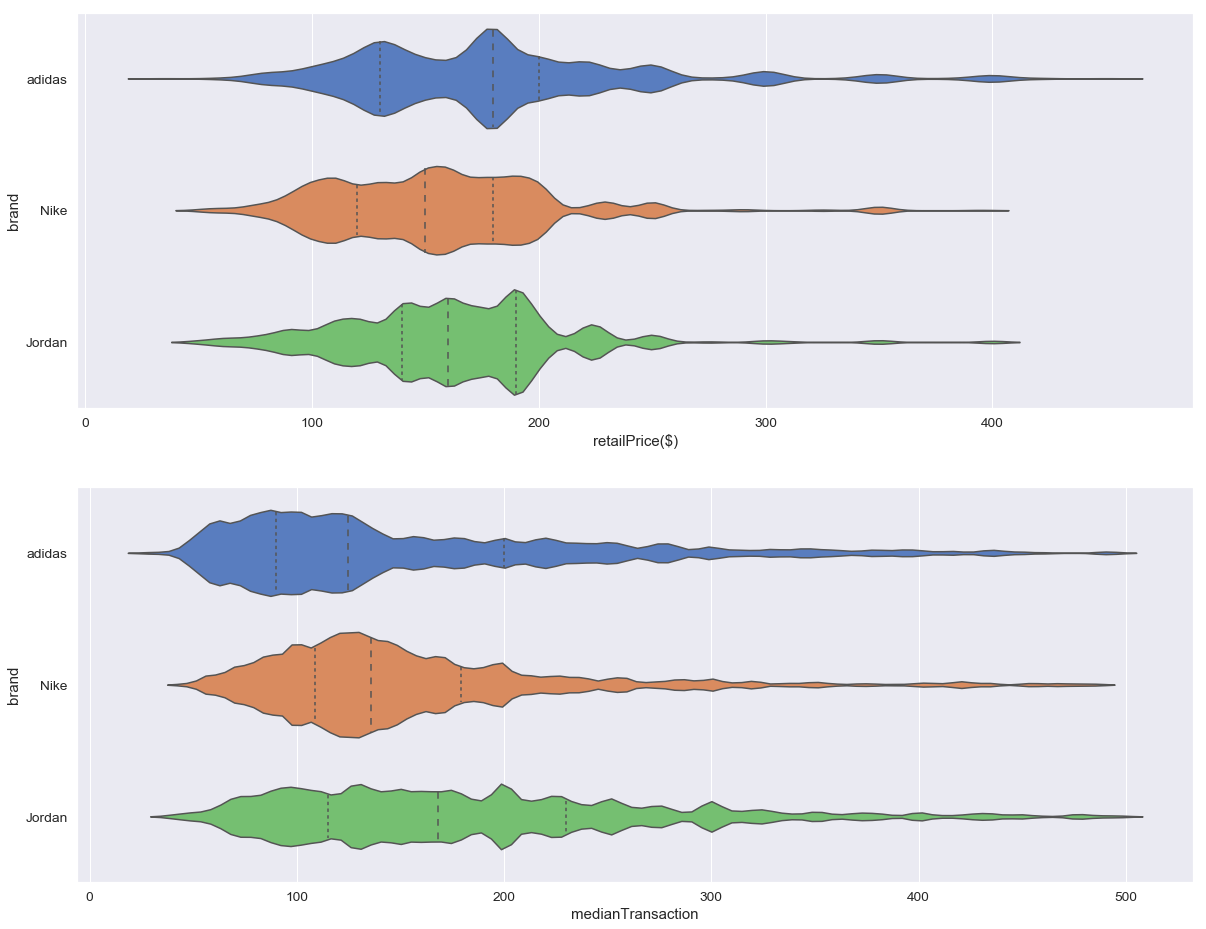

In [76]:
#  Violin plots for the 3 different brands
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,16))
sns.set(font_scale = 1.25)

ax1 = sns.violinplot(x="retailPrice($)", y="brand",
                    data=df_no_na[df_no_na['retailPrice($)']<500],
                    palette="muted", bw=0.125, ax=ax1,
                    inner="quartile")

ax2 = sns.violinplot(x="medianTransaction", y="brand",
                    data=df_no_na[df_no_na['medianTransaction']<500],
                    palette="muted", bw=0.05, ax=ax2,
                    inner="quartile")


In [77]:
df.describe()

,retailPrice($),averageTransaction,totalTransactions,medianTransaction,averagePremiumPrice(%),medianProfit,medianPremiumPrice(%)
count,2755.000000,2859.000000,2859.000000,2859.000000,2755.000000,2755.000000,2755.000000
mean,168.746642,272.324898,2051.660021,260.531022,38.873162,58.637860,33.190287
std,67.972684,778.429299,5285.457886,733.701386,208.247445,344.790063,191.894225
min,35.000000,27.500000,1.000000,27.500000,-80.360000,-325.000000,-80.360000
25%,130.000000,111.084765,177.500000,105.000000,-26.865000,-45.000000,-29.130000
50%,160.000000,152.912944,579.000000,150.000000,-1.660000,-6.000000,-4.580000
75%,190.000000,233.811587,1883.500000,229.250000,33.835000,48.500000,30.800000
max,1425.000000,26037.384615,86303.000000,26000.000000,4349.240000,7300.000000,3763.850000


In [78]:
unique_vals = df['brand'].unique()  # [0, 1, 2]
unique_vals

array(['adidas', 'Nike', 'Jordan'], dtype=object)

In [79]:
#  checking for normality the 3 different brands
from scipy import stats

adi_shapiro_retail = stats.shapiro(adi_chunk['retailPrice($)'])
jord_shapiro_retail =  stats.shapiro(jord_chunk['retailPrice($)'])
nike_shapiro_retail =  stats.shapiro(nike_chunk['retailPrice($)'])

print(f'adi_shapiro_retail P value is {adi_shapiro_retail[-1]}')
print(f'jord_shapiro_retail P value is {jord_shapiro_retail[-1]}')
print(f'nike_shapiro_retail P value is {nike_shapiro_retail[-1]}')

adi_shapiro_avg_txn = stats.shapiro(adi_chunk['averageTransaction'])
jord_shapiro_avg_txn =  stats.shapiro(jord_chunk['averageTransaction'])
nike_shapiro_avg_txn =  stats.shapiro(nike_chunk['averageTransaction'])

print('')
print(f'adi_shapiro_avg_txn P value is {adi_shapiro_avg_txn[-1]}')
print(f'jord_shapiro_avg_txn P value is {jord_shapiro_avg_txn[-1]}')
print(f'nike_shapiro_avg_txn P value is {nike_shapiro_avg_txn[-1]}')

adi_shapiro_retail P value is 2.7438971373939477e-33
jord_shapiro_retail P value is 8.102819454716622e-27
nike_shapiro_retail P value is 1.8307263787171573e-40

adi_shapiro_avg_txn P value is 0.0
jord_shapiro_avg_txn P value is 0.0
nike_shapiro_avg_txn P value is 0.0


**As all the p values are < 0.05, we can assume none of the distributions are normal**

## Total number of shoes with a retail price is 2755


In [80]:
## Showing sneakers with the most models and their brands ##
############################################################

#  selecting top 12 of the most common models of sneaker being sold
df_grouped_by_model = df_no_na.groupby(['brand','model']).count().sort_values(['color'], ascending=False).head(12).reset_index()
df_grouped_by_model.head()

,brand,model,color,itemCondition,name,releaseDate,sku,image,url,retailPrice($),transactionHistory,averageTransaction,totalTransactions,medianTransaction,averagePremiumPrice(%),medianProfit,medianPremiumPrice(%)
0,Jordan,Jordan 1 Retro High,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
1,adidas,adidas NMD R1,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94
2,Jordan,Jordan 1 Mid,93,93,93,93,93,93,93,93,93,93,93,93,93,93,93
3,Jordan,Jordan 4 Retro,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74
4,Nike,Air Force 1 Low,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65


In [81]:
#  Getting probability density of each shoe model and converting to df so I can merge to previous grouped df
shoe_models_probability_density = df_no_na['model'].value_counts(normalize=True)
shoe_models_probability_density = shoe_models_probability_density.head(12)
shoe_models_probability_density = shoe_models_probability_density.rename('Probability Density')
shoe_models_probability_density = shoe_models_probability_density.to_frame().reset_index().rename(columns={"index": "model"})
shoe_models_probability_density

,model,Probability Density
0,Jordan 1 Retro High,0.036298
1,adidas NMD R1,0.034120
2,Jordan 1 Mid,0.033757
3,Jordan 4 Retro,0.026860
4,Air Force 1 Low,0.023593
5,adidas Ultra Boost 4.0,0.020327
6,adidas Yeezy Boost 350 V2,0.019601
7,Jordan 12 Retro,0.019238
8,Jordan 6 Retro,0.018512
9,Air Max 1,0.017423


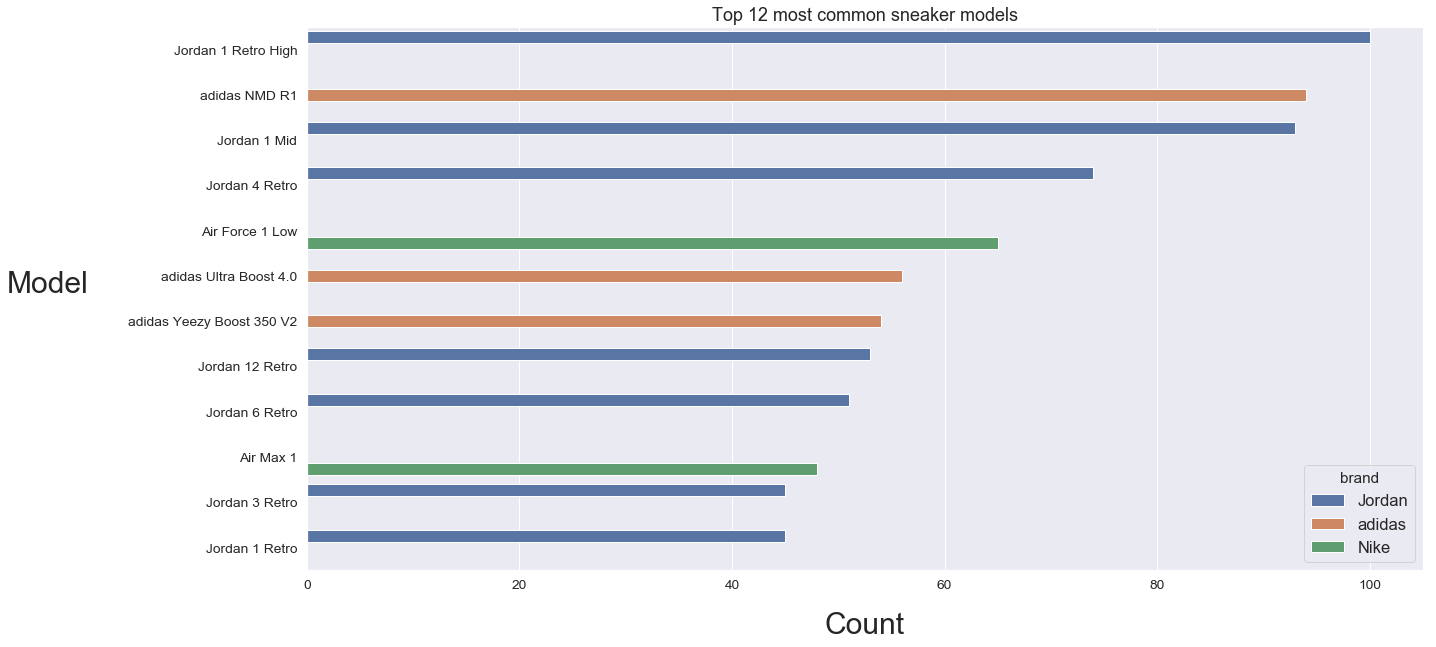

In [82]:
# Merging probability density into grouped model df as I already have it 
df_grouped_by_model_with_probability_densites =  pd.merge(df_grouped_by_model,
                                                            shoe_models_probability_density, 
                                                            on = 'model')
df_grouped_by_model_with_probability_densites
fig, ax = plt.subplots(1, figsize=(20,10))
sns.set(font_scale = 1.5)
ax = sns.barplot(x="color", y="model", data=df_grouped_by_model_with_probability_densites, hue='brand')
ax.set_title('Top 12 most common sneaker models')
ax.set_xlabel('Count', rotation=0, fontsize=30, labelpad=20)
ax.set_ylabel('Model', rotation=0, fontsize=30, labelpad=80);

**TODO: ANALYSE WHICH MODELS OF SHOES MADE THE MOST PROFIT ON AVERAGE AND TRY TO SEE WHAT MADE THEM SO POPULAR**

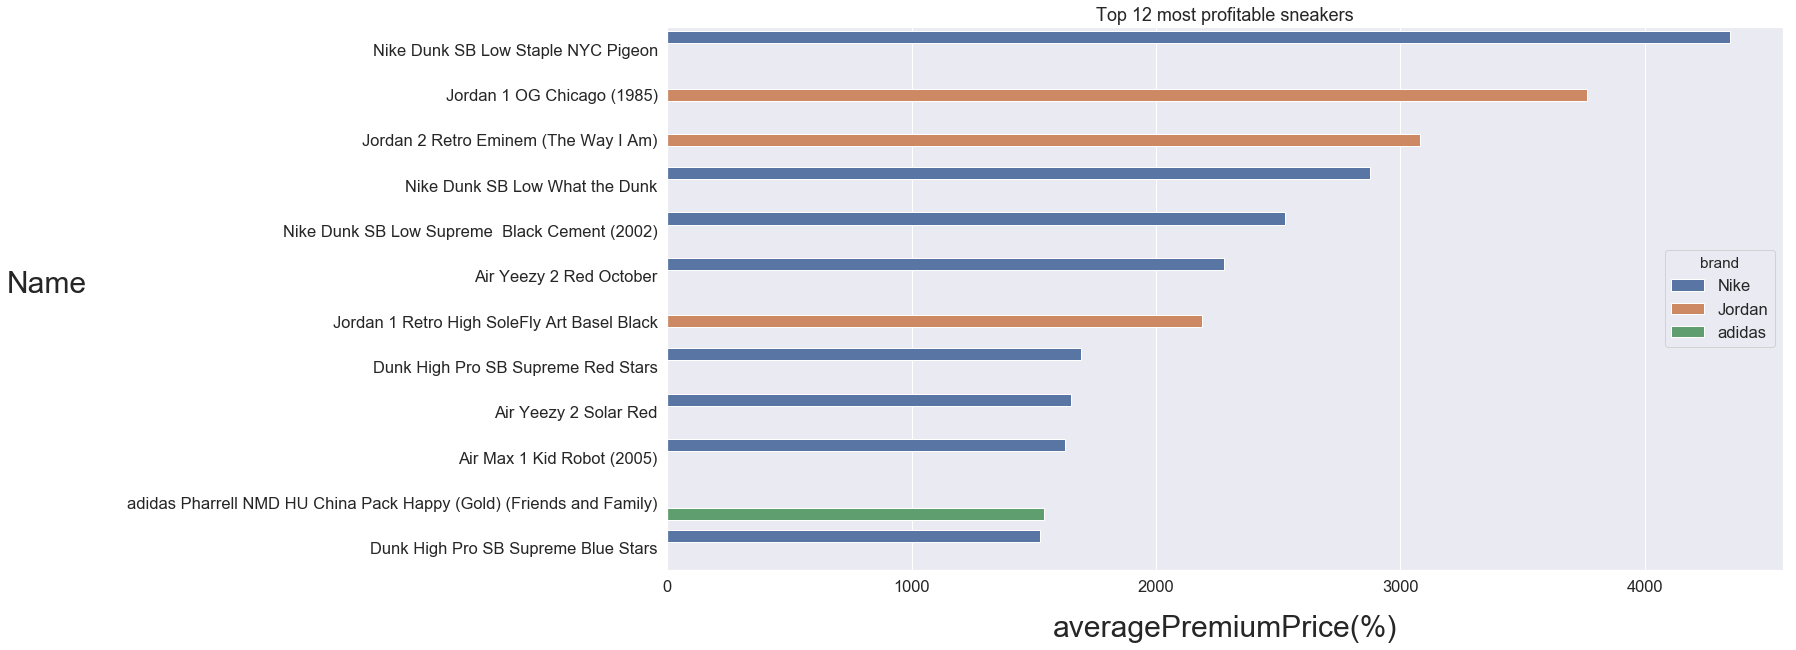

In [83]:
#  Listing top 12 trainers with highest profits
var_for_profit = "averagePremiumPrice(%)" # choose from "averagePremiumPrice(%)", "medianPremiumPrice(%)", "medianProfit"

df_no_na.sort_values(by=var_for_profit, ascending=False).iloc[0]['url']
df_top_12_profitable = df_no_na.sort_values(by=var_for_profit, ascending=False).head(12)

fig, ax = plt.subplots(1, figsize=(20,10))
sns.set(font_scale = 1.5)

ax = sns.barplot(x=var_for_profit, y="name", data=df_top_12_profitable, hue='brand')
ax.set_title('Top 12 most profitable sneakers')
ax.set_xlabel(var_for_profit, rotation=0, fontsize=30, labelpad=20)
ax.set_ylabel('Name', rotation=0, fontsize=30, labelpad=80);

In [84]:
df_top_12_profitable[['name', 'model','medianProfit', 'medianPremiumPrice(%)','averagePremiumPrice(%)', 'totalTransactions', 'retailPrice($)', 'releaseDate']]

,name,model,medianProfit,medianPremiumPrice(%),averagePremiumPrice(%),totalTransactions,retailPrice($),releaseDate
1111,Nike Dunk SB Low Staple NYC Pigeon,Nike Dunk SB Low,7300.0,3650.00,4349.24,17,200.0,2005-03-01
2052,Jordan 1 OG Chicago (1985),Jordan 1 OG,2446.5,3763.85,3763.85,2,65.0,1985-09-16
2045,Jordan 2 Retro Eminem (The Way I Am),Jordan 2 Retro,3340.0,3036.36,3078.45,27,110.0,2008-12-18
1090,Nike Dunk SB Low What the Dunk,Nike Dunk SB Low,2480.0,2066.67,2873.94,83,120.0,2007-10-01
1102,Nike Dunk SB Low Supreme Black Cement (2002),Nike Dunk SB Low,1600.0,2461.54,2529.67,28,65.0,2002-09-01
1057,Air Yeezy 2 Red October,Air Yeezy 2,5250.0,2100.00,2278.05,334,250.0,2014-02-09
2495,Jordan 1 Retro High SoleFly Art Basel Black,Jordan 1 Retro High,3440.0,2150.00,2186.19,121,160.0,2018-12-08
1063,Dunk High Pro SB Supreme Red Stars,Dunk High Pro SB,925.0,1233.33,1692.67,16,75.0,2003-08-08
1085,Air Yeezy 2 Solar Red,Air Yeezy 2,4050.0,1620.00,1654.07,217,250.0,2012-06-09
1119,Air Max 1 Kid Robot (2005),Air Max 1,2350.0,1566.67,1628.94,12,150.0,2005-02-11


#### Reasons why they may be top selling (from StockX):
- Nike Dunk SB Low Staple NYC Pigeon: Only 150 released, police had to escort buyers home, only 3 sales
- adidas Human Race NMD Pharrell x Chanel: Very high retail price of 1,160 dollars, 11 sales
- Nike Air Yeezy 2 Red October: Very famous sneaker, 57 sales
- Nike Air Yeezy 2 Solar Red: Another quite famous sneaker, 39 sales
- adidas Pharrell NMD HU China Pack Happy (Gold) (Friends and Family): Available exclusively in China at release, 300 pairs, 9 sales
- Jordan 1 Retro High SoleFly Art Basel Black: It is believed that there is only 23 pairs available of this colorway making it one of rarest Jordan 1s of all-time.68 sales
- Jordan 2 Retro Eminem (The Way I Am): Only 313 pairs of the Air Jordan 2 (II) Retro Eminem, and this signify Slim Shady’s hometown, Detroit. Also, you would receive a XL T-Shirt with “The Way I am” printed across the chest (official Jordan Brand). Released December 18th 2008 with a retail price of 110 dollars. Sadly, they sold out in minutes. 8 sales only
- adidas NMD HU Pharrell Y.O.U. N.E.R.D.: 18 sales only
- Nike Air Yeezy 2 Pure Platinum: Another yeezy, 47 sales
- Nike Air Yeezy 1 Blink: Another 1; 13 sales
- Nike Dunk SB Low What the Dunk: 33 sales, These sneakers are extremely rear, and almost impossible to get in a deadstock condition. There was less then 2000 pairs released worldwide.
- Jordan 1 OG Chicago (1985): I think they are vintage and really old..., only 2 sales

#### Features of the most profitable sneakers
The most profitable sneakers seem to have a common characteristic of being limited edition as well as affiliated to celebrities. 4 of Kanye's Nike models are in the top 12. There's Eminem, 2 models from Pharell.
 - Celebrities
 - Limited amount released

**Note:**
- I'm not sure whether to use mean or median premium prices when looking at the profitability of these sneakers

**So conclusion is maybe I need to look at most profitable models? The list above is most profitable because of how rare the sneakers are**

In [85]:
#  Analysing which are the most profitable sneaker models
var_for_profit = "averagePremiumPrice(%)" # choose from "averagePremiumPrice(%)", "medianPremiumPrice(%)", "medianProfit"

#  grouping by model and getting mean of profitability variable
df_models_profit = df_no_na.groupby(['model'])[var_for_profit].mean().sort_values(ascending=False).to_frame().reset_index().rename(columns={"index": "model"})

#  grouping by model and getting count of different models
df_models_count = df_no_na.groupby(['model'])[var_for_profit].count().sort_values(ascending=False).to_frame().reset_index().rename(columns={"index": "model", var_for_profit: "modelCount"})

#  #  grouping by model and getting count of total transactions for each model
df_models_transaction_count = df_no_na.groupby(['model'])['totalTransactions'].sum().sort_values(ascending=False).to_frame().reset_index().rename(columns={"index": "model"})

df_models_profit_count = pd.merge(df_models_profit, df_models_count, on='model')
df_models_profit_count_transactions = pd.merge(df_models_profit_count, df_models_transaction_count, on='model')

# adding back brand column to the df for graphing and dropping duplicates
df_models_profit_count_transactions = pd.merge(df_models_profit_count_transactions,
                                               df_no_na[['brand', 'model']],
                                               on='model',
                                               how='left').drop_duplicates(subset ="model") 

top_12_most_profitable_models = df_models_profit_count_transactions.head(12)
top_12_most_profitable_models

,model,averagePremiumPrice(%),modelCount,totalTransactions,brand
0,Jordan 1 OG,3763.850000,1,2,Jordan
1,Air Yeezy 2,1730.833333,3,805,Nike
4,Dunk High Pro SB,1608.870000,2,36,Nike
6,Nike Dunk SB Low,1384.930000,8,3828,Nike
14,Air Yeezy 1,995.880000,2,165,Nike
16,Air Max 1 NL,826.980000,1,42,Nike
17,NikeCraft Mars Yard Shoe 2.0,668.650000,1,543,Nike
18,KD 4,609.340000,3,1541,Nike
21,adidas 3D Runner,598.230000,1,37,adidas
22,adidas NMD HU,592.055000,4,2346,adidas


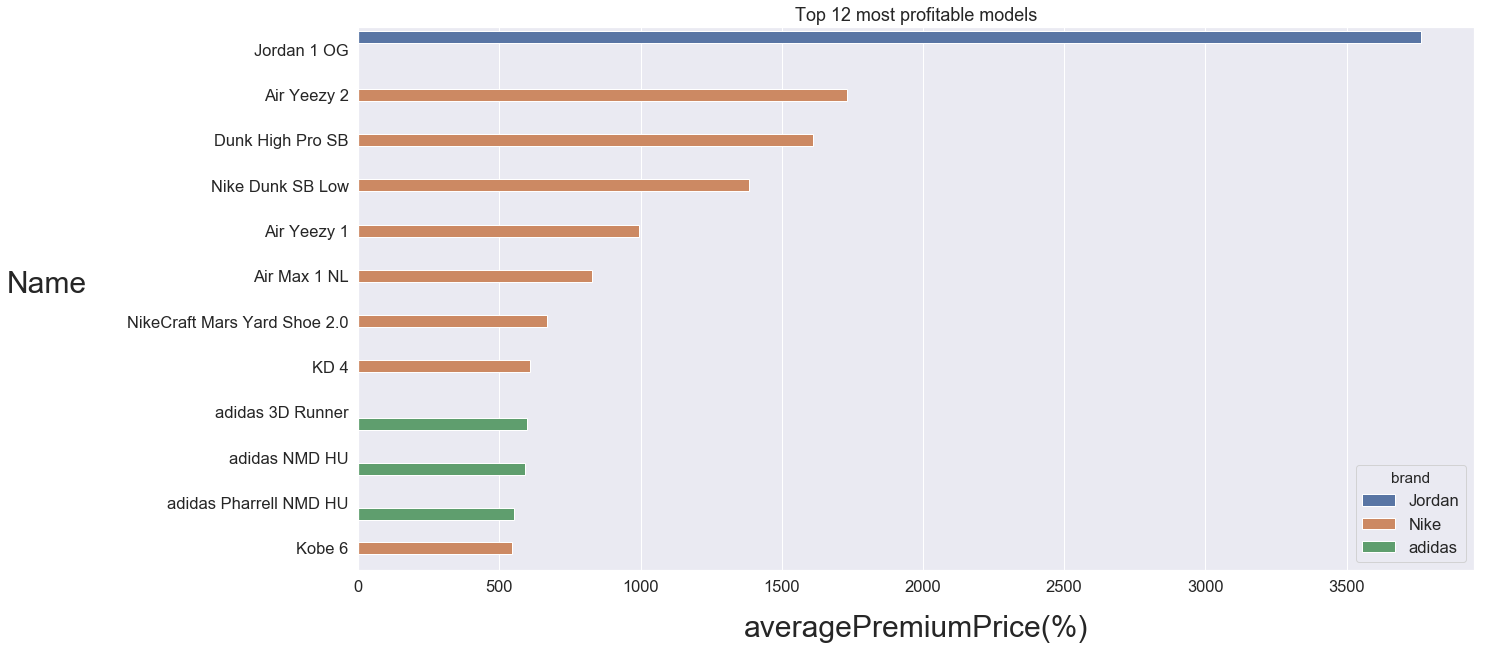

In [86]:
fig, ax = plt.subplots(1, figsize=(20,10))
sns.set(font_scale = 1.5)

ax = sns.barplot(x=var_for_profit, y="model", data=top_12_most_profitable_models, hue='brand')
ax.set_title('Top 12 most profitable models')
ax.set_xlabel(var_for_profit, rotation=0, fontsize=30, labelpad=20)
ax.set_ylabel('Name', rotation=0, fontsize=30, labelpad=80);

In [87]:
#  Inspecting inidividual models
model_name = 'KD 4'
model_inspection_df = df_no_na.loc[df_no_na['model'] == model_name]

cols_to_view = [
    'name',
    'model',
    'medianProfit',
    'averagePremiumPrice(%)',
    'totalTransactions',
    'retailPrice($)',
    'releaseDate',
    'color'
]

model_inspection_df[cols_to_view]

,name,model,medianProfit,averagePremiumPrice(%),totalTransactions,retailPrice($),releaseDate,color
1061,KD 4 Weatherman,KD 4,705.0,781.86,59,95.0,2011-12-10,Stadium Green/Volt-Black-Team Orange
1098,KD 4 Nerf,KD 4,1275.0,1055.40,41,125.0,2011-12-17,Concord/Bright Crimson-Black-C (Nerf)
1824,KD 4 Think 16 (Thunderstruck),KD 4,-18.0,-9.24,1441,140.0,2018-06-07,White/Photo Blue-Wolf Grey-Black


#### Observation:
As expeceted, a lot of the most profitable models are affiliated to celebrities. We se  3 Kanye's (2 Nike, 1 Adidas), Lebron, Pharell. Another thing to note is that there aren't many variations of the models. The highest count was 9.

In [88]:
#  Merging the weekly transactions for each shoe
df_with_weekly_transactions = pd.merge(df, profit_per_week_df_pivoted, on='sku', how='outer')

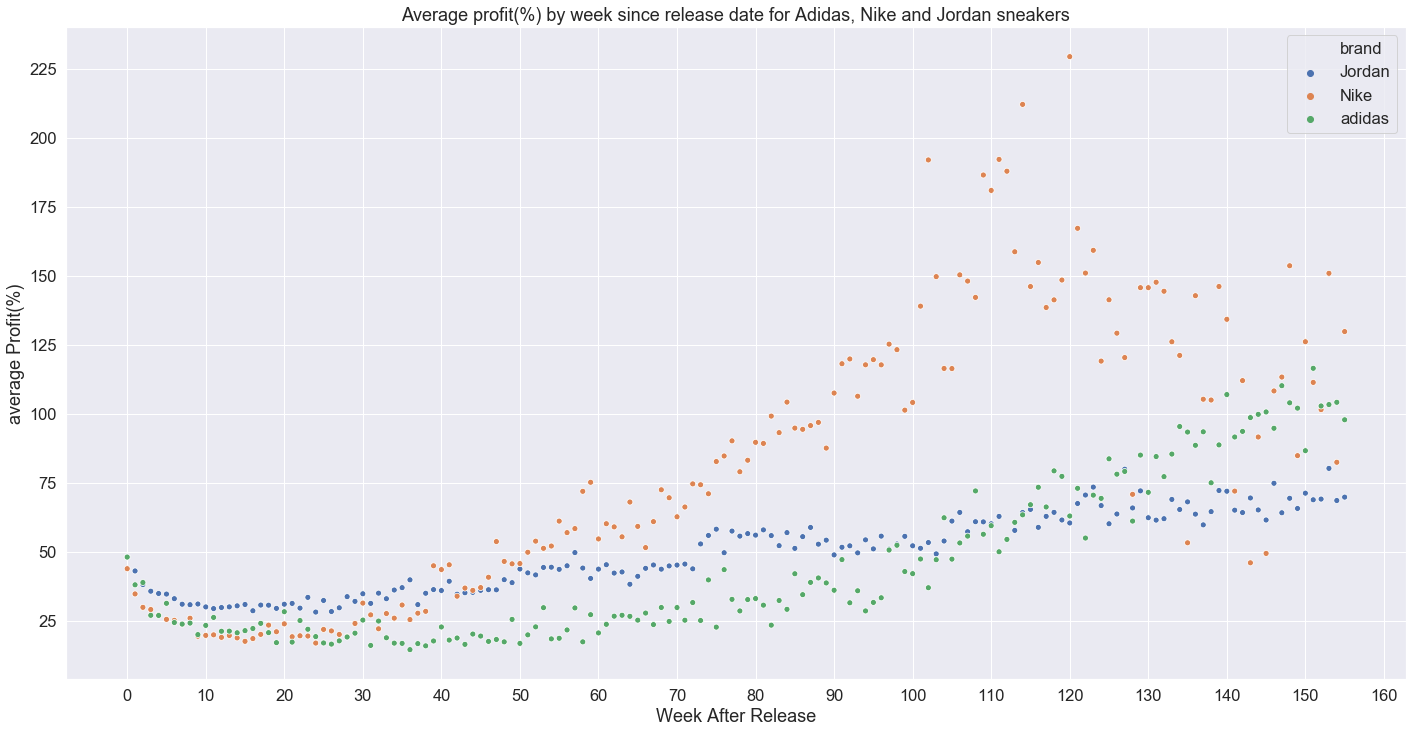

In [89]:
import matplotlib.ticker as ticker

#  Reshaping df so we can get a column for week of transaction and average transaction for that week
df_with_weekly_transactions_trimmed = df_with_weekly_transactions[['name', 'brand', *list(range(0,156))]]

df_with_weekly_transactions_trimmed_melted = df_with_weekly_transactions_trimmed.melt(id_vars=["name", "brand"],
                                                                                       var_name='weekOfTransaction',
                                                                                       value_name="averageTransactionProfit(%)")

#  Scatter Plot, grouped by brand
df_with_weekly_transactions_trimmed_melted_grouped = df_with_weekly_transactions_trimmed_melted.groupby(['brand',
                                                                                                           'weekOfTransaction'])['averageTransactionProfit(%)'].mean().reset_index()
sns.set()
sns.set(font_scale = 1.5)
fig, ax1 = plt.subplots(figsize=(24, 12))
plt.grid()

sns.scatterplot(x='weekOfTransaction',
                y='averageTransactionProfit(%)',
                hue='brand',
                data=df_with_weekly_transactions_trimmed_melted_grouped,
                ax=ax1)

plt.grid()


ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

ax1.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax1.set_ylabel('average Profit(%)')
ax1.set_xlabel('Week After Release')
ax1.set_title('Average profit(%) by week since release date for Adidas, Nike and Jordan sneakers');


#### Observation
From the scatter plot above, it is clear that investments in Nike trainers are worth more if you hold them out for longer. In between 0 - 1.5 years after releae, it's Adidas that's the lowest with Jordan being more worth it. However after that, Adidas overtakes at around week 120 to be more profitable than Jordans.

**As the plot above concerns ALL sneakers that each brand has released, let's dive into something more specific, like Yeezys from Adidas, and see if there is anything interesting there**

In [90]:
#  Selecting only adidas Yeezys
adi_chunk_weekly_df = df_with_weekly_transactions.loc[df_with_weekly_transactions['brand'] == 'adidas']
yeezy_weekly_df = adi_chunk_weekly_df[adi_chunk_weekly_df['model'].str.contains('Yeezy', case=False)]

In [91]:
#  How many models for each adidas Yeezy
yeezy_weekly_df_model_count = yeezy_weekly_df.groupby(['model']).count().reset_index().rename(columns={"index": "model",
                                                                         'color': "modelCount"})[['model',
                                                                                                  'modelCount']].sort_values(ascending=False,
                                                                                                                             by='modelCount')
                                                                                                                             

#  Adding earliest release date    
yeezy_weekly_df_model_count = pd.merge(yeezy_weekly_df_model_count, yeezy_weekly_df.groupby(['model'])['releaseDate'].min(), on='model')                                                                                                                    
yeezy_weekly_df_model_count = yeezy_weekly_df_model_count.rename(columns={"releaseDate": "firstReleaseDate"})

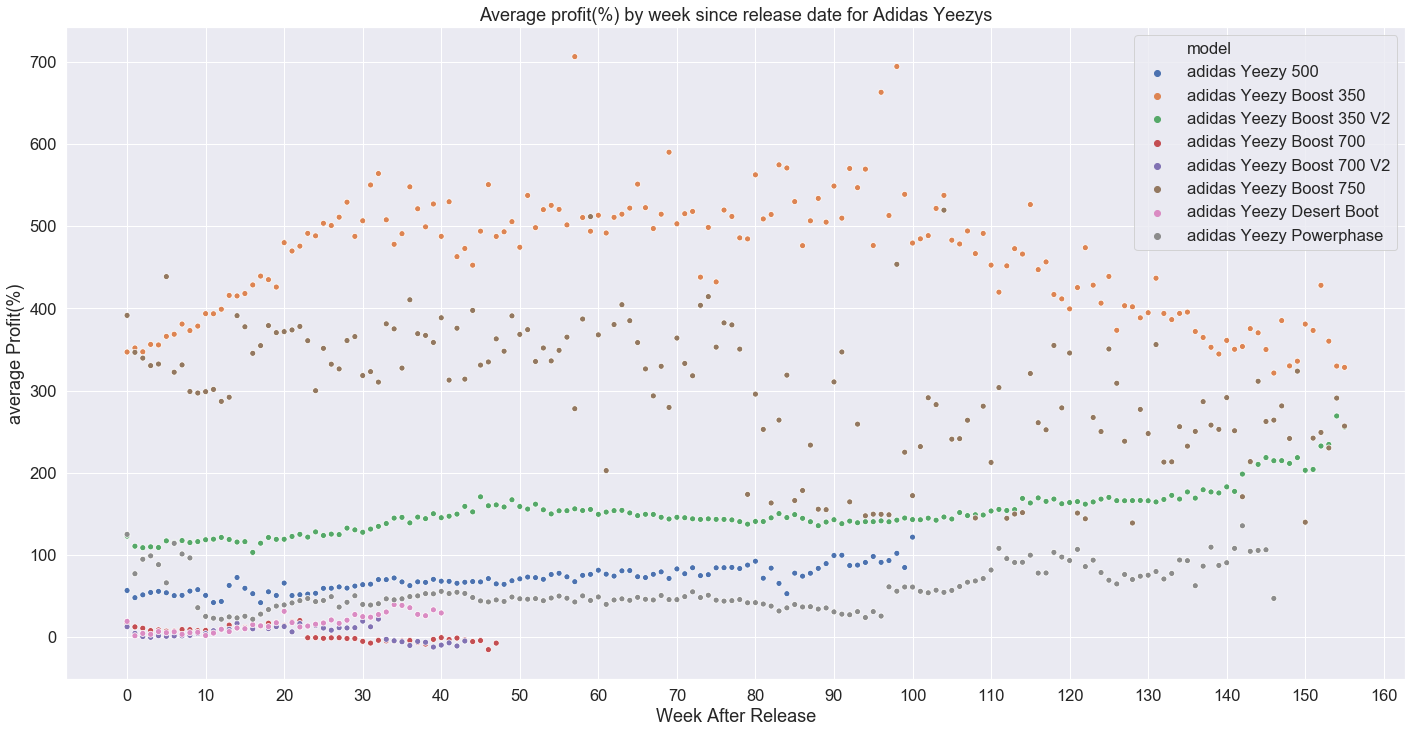

In [92]:
#  Grouping all the yeezy models and averaging the weekly profits
yeezy_weekly_df_model_grouped = yeezy_weekly_df.groupby(['model'])[list(range(0,156))].mean().reset_index()

yeezy_weekly_df_melted = yeezy_weekly_df_model_grouped.melt(id_vars=["model"],
                                              var_name='weekOfTransaction',
                                              value_name="averageTransactionProfit(%)")

#  Scatter Plot, grouped by model
yeezy_weekly_df_melted_grouped  = yeezy_weekly_df_melted.groupby(['model',
                                                                  'weekOfTransaction'])['averageTransactionProfit(%)'].mean().reset_index()


#  Adding Model Count df
yeezy_grouped_with_model_count = pd.merge(yeezy_weekly_df_melted_grouped, yeezy_weekly_df_model_count,
                                          on='model',
                                          how='outer')

#  Selecting yeezys that have more than one variation of a model
more_than_one_yeezy_model_df = yeezy_grouped_with_model_count.loc[yeezy_grouped_with_model_count['modelCount'] > 1]


sns.set()
sns.set(font_scale = 1.5)
fig, ax1 = plt.subplots(figsize=(24, 12))
plt.grid()

sns.scatterplot(x='weekOfTransaction',
                y='averageTransactionProfit(%)',
                hue='model',
                data=more_than_one_yeezy_model_df,
                ax=ax1)

plt.grid()


ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

#  ax1.yaxis.set_major_locator(ticker.MultipleLocator(25))
#  ax1.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax1.set_ylabel('average Profit(%)')
ax1.set_xlabel('Week After Release')
ax1.set_title('Average profit(%) by week since release date for Adidas Yeezys');

In [93]:
#  Ordering the average transaction profit over all weeks and checking correlation between date of first release of given model
more_than_one_yeezy_model_df.groupby(['model','firstReleaseDate'])['averageTransactionProfit(%)'].mean().reset_index().sort_values(by='averageTransactionProfit(%)', ascending=False)

,model,firstReleaseDate,averageTransactionProfit(%)
1,adidas Yeezy Boost 350,2015-06-27,463.712441
5,adidas Yeezy Boost 750,2015-02-14,298.671810
2,adidas Yeezy Boost 350 V2,2016-09-24,152.334168
0,adidas Yeezy 500,2018-02-16,70.638348
7,adidas Yeezy Powerphase,2017-03-28,58.329053
6,adidas Yeezy Desert Boot,2019-04-13,17.010505
4,adidas Yeezy Boost 700 V2,2019-03-23,5.165773
3,adidas Yeezy Boost 700,2019-02-23,3.653913


##### Observation
Trend for profit over time is relatively flat for all average of models since date of release. Only the first Yeezy released showed an initial increase in profits. In addition, average progit from each Yeezy decreases as more models come out, shown by decreasing average transaction profit as first release date for models increases.

In [94]:
df_no_na.count()['color']

2755

In [95]:
len(df_no_na['color'].unique())

2127

In [96]:
df_no_na.count()['color']-len(df_no_na['color'].unique())

628

In [97]:
# method that will take subset of each model and rank it by date
def get_subset_model_dfs(df):
    model_names = df['model'].unique()
    return [df.loc[df['model'] == model_name] for model_name in model_names]

def assign_ranks_by_release_date(model_dfs: list):
    ranked_models= []
    for df in model_dfs:
        df['releaseDate'] =  pd.to_datetime(df['releaseDate'])
        df['releaseRank'] = df['releaseDate'].rank()
        ranked_models.append(df)
    return ranked_models 
    
def do_all(df):
    model_dfs = get_subset_model_dfs(df)
    ranked_model_dfs = assign_ranks_by_release_date(model_dfs)
    return pd.concat(ranked_model_dfs)

subset_model_dfs = get_subset_model_dfs(df_no_na)
ranked_subset_model_dfs = assign_ranks_by_release_date(subset_model_dfs)
ranked_models_df = pd.concat(ranked_subset_model_dfs)

/Users/janzajac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/janzajac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


The coefficient of correlation is: 0.020794345263465085


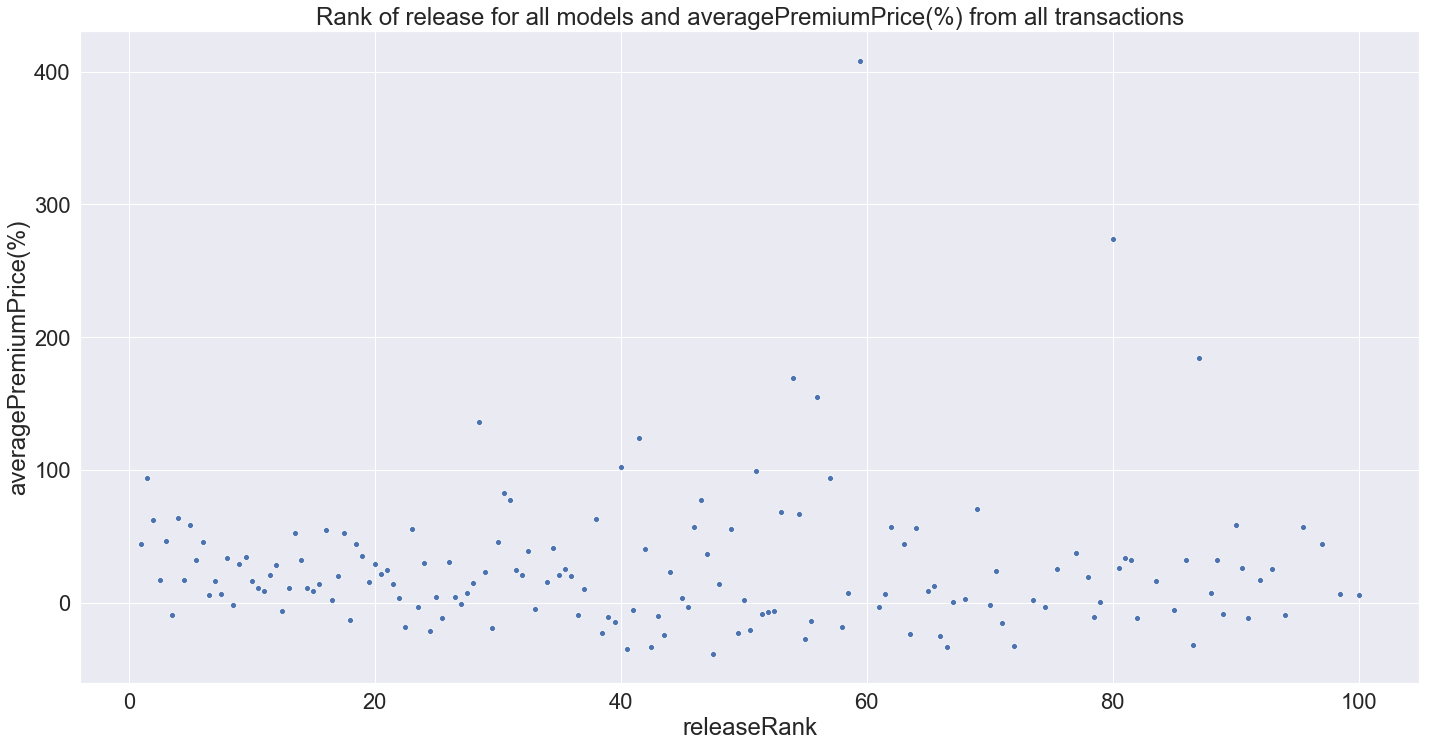

In [46]:
#  Scatter plot to observe whether the order of the models has an affect on the value of the shoe (are later models worth less?)
var_for_profit = "averagePremiumPrice(%)" # choose from "averagePremiumPrice(%)", "medianPremiumPrice(%)", "medianProfit"
grouped_by_rank_df = ranked_models_df.groupby(['releaseRank'])[var_for_profit].mean().reset_index()



print(f'The coefficient of correlation is: {grouped_by_rank_df.corr(method="pearson").iloc[0][var_for_profit]}')

sns.set(font_scale = 2)
fig, ax1 = plt.subplots(figsize=(24, 12))
ax1.set_title(f'Rank of release for all models and {var_for_profit} from all transactions')
plt.grid()

sns.scatterplot(x='releaseRank',
                y=var_for_profit,
                data=grouped_by_rank_df,
                ax=ax1)
#plt.xlim(0, 20);
plt.grid()



In [98]:
for name in ranked_models_df['name'].unique():
    print(name)


adidas Yeezy Boost 350 V2 Yecheil (Non-Reflective)
adidas Yeezy Boost 350 V2 Zebra
adidas Yeezy Boost 350 V2 Yeezreel (Non-Reflective)
adidas Yeezy Boost 350 V2 Cloud White (Non-Reflective)
adidas Yeezy Boost 350 V2 Citrin (Non-Reflective)
adidas Yeezy Boost 350 V2 Cream/Triple White
adidas Yeezy Boost 350 V2 Lundmark (Non Reflective)
adidas Yeezy Boost 350 V2 Sesame
adidas Yeezy Boost 350 V2 Clay
adidas Yeezy Boost 350 V2 Semi Frozen Yellow
adidas Yeezy Boost 350 V2 Static Black (Reflective)
adidas Yeezy Boost 350 V2 Static (Non-Reflective)
adidas Yeezy Boost 350 V2 Butter
adidas Yeezy Boost 350 V2 Antlia (Non-Reflective)
adidas Yeezy Boost 350 V2 Synth (Non-Reflective)
adidas Yeezy Boost 350 V2 Beluga 2.0
adidas Yeezy Boost 350 V2 Blue Tint
adidas Yeezy Boost 350 V2 Glow
adidas Yeezy Boost 350 V2 Static Reflective
adidas Yeezy Boost 350 V2 Trfrm
adidas Yeezy Boost 350 V2 Black Red
adidas Yeezy Boost 350 V2 Hyperspace
adidas Yeezy Boost 350 V2 Beluga
adidas Yeezy Boost 350 V2 Core Bla

Jordan 11 Retro 72-10 (GS)
Jordan 11 Retro UNC Win Like 82 (GS)
Jordan 11 Retro Platinum Tint (GS)
Jordan 11 Retro Cool Grey (2010)
Jordan 11 Retro Concord 2018 (PS)
Jordan 11 Retro Space Jam (2009)
Jordan 11 Retro Pantone
Jordan 11 Retro Playoffs (2001)
Jordan 11 Retro Concord 2018 (TD)
Jordan 11 Retro Heiress Night Maroon (GS)
Jordan 1 Retro High Fearless UNC Chicago
Jordan 1 Retro High Shattered Backboard 3.0
Jordan 1 Retro High Obsidian UNC
Jordan 1 Retro High Bloodline
Jordan 1 Retro High Fearless Zoom
Jordan 1 Retro High Travis Scott
Jordan 1 Retro High Satin Black Toe (W)
Jordan 1 Retro High Black Crimson Tint
Jordan 1 Retro High First Class Flight
Jordan 1 Retro High Phantom Gym Red
Jordan 1 Retro High Turbo Green
Jordan 1 Retro High Neutral Grey Hyper Crimson
Jordan 1 Retro High Shadow (2018)
Jordan 1 Retro High Rookie of the Year
Jordan 1 Retro High Turbo Green (GS)
Jordan 1 Retro High Bred Toe
Jordan 1 Retro High Defiant White Black Gym Red
Jordan 1 Retro High Spider-Man Ori

In [99]:
collab_names = ['Yeezy',
 'Pharell',
 'Eminem',
 'Kobe',
 'Lebron',
 'Eddie Huang',
 'Stella McCartney',
 'Daniel Arsham',
 'Donald Glover',
 'Pusha T',
 'Raf Simons',
 'Helen Kirkum',
 'Alex Nash'
 'Shun Hirose',
 'Alexander Wang',
 'Liam Gallagher',
 'Beastie Boys',
 'Busenitz',
 'Gucci',
 'Zidane',
 'Keith Haring',
 'Travis Scott',
 'Cactus Jack',
 'Olivia Kim',
 'Roc-A-Fella',
 'Colin Kaepernick',
 'Devin Booker',
 'Carhartt',
 'Comme des Garcons',
 'Kendrick Lamar',
 'Ronaldo',
 'Curry',
 'OFF-WHITE',
 'Off-White',
 'Kyrie',
 'Riccardo Tisci',
 'Skepta',
 'Kylian Mbappe',
 'Wu-Tang',
 'Beckham',
 'Barry Sanders',
 'Nyjah',
 'Swarovski',
 'Matthew Williams',
 'Nigel Sylvester',
 "Levi's",
 'Johnny Kilroy',
 'Maya Moore',
 'Drake',
 'Russell Westbrook',
 'OVO',
 'Craig Stecyk',
 'Lance Mountain',
 'Bape',
 'Billionaire Boys Club',
 'BBC']

collab_single_names = ['Yeezy',
 'Pharell',
 'Eminem',
 'Kobe',
 'Lebron',
 'Huang',
 'McCartney',
 'Arsham',
 'Glover',
 'Pusha',
 'Simons',
 'Kirkum',
 'Nash'
 'Hirose',
 'Wang',
 'Gallagher',
 'Beastie',
 'Busenitz',
 'Gucci',
 'Zidane',
 'Haring',
 'Travis',
 'Cactus',
 'Olivia',
 'Roc-A-Fella',
 'Kaepernick',
 'Booker',
 'Carhartt',
 'Garcons',
 'Kendrick',
 'Ronaldo',
 'Curry',
 'OFF-WHITE',
 'Off-White',
 'Kyrie',
 'Tisci',
 'Skepta',
 'Mbappe',
 'Wu-Tang',
 'Beckham',
 'Sanders',
 'Nyjah',
 'Swarovski',
 'Williams',
 'Nigel Sylvester',
 "Levi's",
 'Kilroy',
 'Moore',
 'Drake',
 'Westbrook',
 'OVO',
 'Stecyk',
 'Lance Mountain',
 'Bape',
 'Billionaire Boys Club',
 'BBC']
        
    
def is_collab(collab_names: list, input_col):
    input_list = input_col.split()
    check = any(item in input_list for item in collab_names)
    if check:
        return 1
    return 0

collab_df = ranked_models_df.copy()
collab_df["Collab"] = collab_df.apply(lambda x: is_collab(collab_single_names, x['name']), axis=1)

In [100]:
collab_grouped = collab_df.groupby(['Collab'])['averagePremiumPrice(%)'].mean().reset_index()

In [101]:
collab_grouped

,Collab,averagePremiumPrice(%)
0,0,29.079686
1,1,103.000301


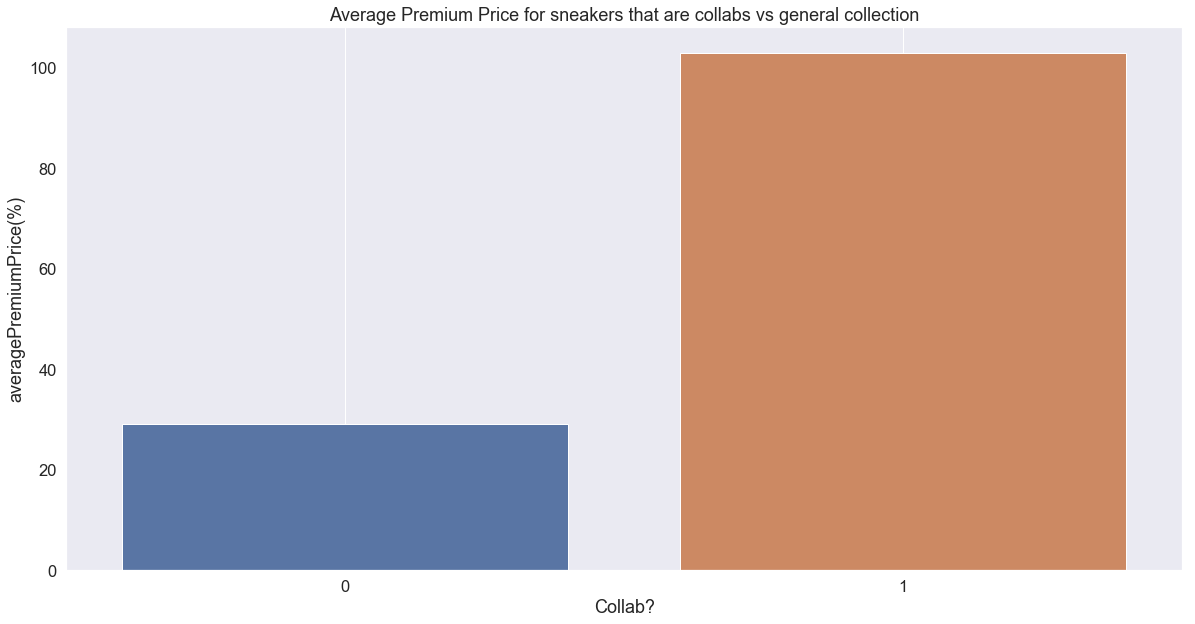

In [102]:
fig, ax1 = plt.subplots(figsize=(20, 10))
var_for_profit = 'averagePremiumPrice(%)'
sns.barplot(x='Collab', y=var_for_profit, data=collab_grouped, ax=ax1)
ax1.set_ylabel(var_for_profit)
ax1.set_xlabel('Collab?')
ax1.set_title('Average Premium Price for sneakers that are collabs vs general collection')
plt.grid()

#### Observation:
Collabs appear to be a lot more special compared to general collection sneakers

In [103]:
for color in collab_df['color'].unique():
    print(color.split('/'))

['Yecheil', 'Yecheil', 'Yecheil']
['White', 'Core Black', 'Red']
['Yeezreel', 'Yeezreel', 'Yeezreel']
['Cloud White', 'Cloud White', 'Cloud White']
['Citrin', 'Citrin', 'Citrin']
['Cream White', 'Cream White']
['Lundmark', 'Lundmark', 'Lundmark']
['Sesame', 'Sesame', 'Sesame']
['Clay', 'Clay', 'Clay']
['Semi Frozen Yellow', 'Raw Steel', 'Red']
['Black', 'Black', 'Black']
['Static', 'Static', 'Static']
['Butter', 'Butter', 'Butter']
['Antlia', 'Antlia', 'Antlia']
['Synth', 'Synth', 'Synth']
['Grey', 'Bold Orange', 'Dark Grey']
['Blue Tint', 'Grey Three', 'High Risk Red']
['Glow', 'Glow', 'Glow']
['Grey', 'Grey', 'Grey']
['Core Black', 'Core Black', 'Red']
['Steeple Gray', 'Beluga', 'Solar Red']
['Core Black', 'Red', 'Core Black']
['Core Black', 'Green', 'Core Black']
['Core Black', 'Core White', 'Core Black']
['Core Black', 'Copper', 'Core Black']
['Azael', 'Azael', 'Azael']
['Grey', 'Grey', 'Inertia']
['Analog', 'Analog', 'Analog']
['Utility Black', 'Utility Black', 'Utility Black']
['

['Summit White', 'Clay Green-Black']
['Orange Peel', 'Orange Peel']
['Blue Lagoon', 'Blue Lagoon']
['Sail', 'Black-Varsity Red']
['White', 'Storm Blue-Varsity Red-Black']
['Sail', 'White-Varsity Red-Reflect Silver']
['Black', 'Black-Starfish-Sail']
['Summit White', 'Blue Moon-Black']
['Cyber', 'Cyber']
['Summit White', 'Yellow Ochre-Black']
['Black', 'Black-Dark Stucco-White']
['Summit White', 'Track Red-Black']
['River Rock', 'Black-University Red-Dark Stucco-White']
['Black', 'Gym Red-White-Sail']
['Guava Ice', 'Sail']
['Pine Green', 'Sail-Black']
['Court Purple', 'Black-Sail']
['Black', 'Black-Metallic Rose-Gold-White']
['Black', 'Black-White-Challenge Red']
['Golden Harvest', 'Golden Harvest-Gum Yellow']
['Black', 'Metallic Gold-Summit White']
['Bordeaux', 'Light Armory Blue-Sunset Tint']
['Black', 'Black-Metallic Field-Light Bone']
['Pale Ivory', 'Phantom-Sail']
['Sail', 'Black-Varsity Maize']
['Beach', 'Black-Ridgerock-Neutral Olive']
['Bio Beige', 'Anthracite-Mystic Green']
['Ic

In [104]:
def split_colours(input_colours):
    input_colours = input_colours.split('/')
    modified_colours = []
    for colour in input_colours:
        if (' ' in colour):
            modified_colours.extend(colour.split())
        elif ('-' in colour):
            modified_colours.extend(colour.split('-'))
        else:
            modified_colours.append(colour)
        
    return modified_colours

def has_black(input_colours):
    modified_colours = split_colours(input_colours) 
    black_list = ['Black', 'BLACK']
    if any(item in modified_colours for item in black_list):
        return 1
    return 0

def has_white(input_colours):
    modified_colours = split_colours(input_colours) 
    white_list = ['White', 'WHITE']
    if any(item in modified_colours for item in white_list):
        return 1
    return 0

def has_red(input_colours):
    modified_colours = split_colours(input_colours) 
    red_list = ['Red', 'RED']
    if any(item in modified_colours for item in red_list):
        return 1
    return 0

def has_yellow(input_colours):
    modified_colours = split_colours(input_colours) 
    yellow_list = ['Yellow', 'YELLOW']
    if any(item in modified_colours for item in yellow_list):
        return 1
    return 0

def has_blue(input_colours):
    modified_colours = split_colours(input_colours) 
    blue_list = ['Blue', 'BLUE']
    if any(item in modified_colours for item in blue_list):
        return 1
    return 0

def has_green(input_colours):
    modified_colours = split_colours(input_colours) 
    green_list = ['Green', 'GREEN']
    if any(item in modified_colours for item in green_list):
        return 1
    return 0

def has_grey(input_colours):
    modified_colours = split_colours(input_colours) 
    grey_list = ['Grey', 'GREy']
    if any(item in modified_colours for item in grey_list):
        return 1
    return 0
                
collab_df["hasBlack"] = collab_df.apply(lambda x: has_black(x['color']), axis=1)
collab_df["hasWhite"] = collab_df.apply(lambda x: has_white(x['color']), axis=1)
collab_df["hasRed"] = collab_df.apply(lambda x: has_red(x['color']), axis=1)
collab_df["hasYellow"] = collab_df.apply(lambda x: has_yellow(x['color']), axis=1)
collab_df["hasBlue"] = collab_df.apply(lambda x: has_blue(x['color']), axis=1)
collab_df["hasGreen"] = collab_df.apply(lambda x: has_green(x['color']), axis=1)
collab_df["hasGrey"] = collab_df.apply(lambda x: has_grey(x['color']), axis=1)


In [105]:
collab_df.head()

,color,model,itemCondition,name,brand,releaseDate,sku,image,url,retailPrice($),...,medianPremiumPrice(%),releaseRank,Collab,hasBlack,hasWhite,hasRed,hasYellow,hasBlue,hasGreen,hasGrey
0,Yecheil/Yecheil/Yecheil,adidas Yeezy Boost 350 V2,https://schema.org/NewCondition,adidas Yeezy Boost 350 V2 Yecheil (Non-Reflect...,adidas,2019-12-20,4a33ef38-2497-4229-8b28-c2fea95cc17c,https://stockx.imgix.net/adidas-Yeezy-Boost-35...,https://stockx.com/adidas-yeezy-boost-350-v2-y...,220.0,...,28.18,53.0,1,0,0,0,0,0,0,0
1,White/Core Black/Red,adidas Yeezy Boost 350 V2,https://schema.org/NewCondition,adidas Yeezy Boost 350 V2 Zebra,adidas,2017-02-25,e90e1888-61f0-4681-8379-a4706e491235,https://stockx.imgix.net/Adidas-Yeezy-Boost-35...,https://stockx.com/adidas-yeezy-boost-350-v2-w...,220.0,...,58.18,8.0,1,1,1,1,0,0,0,0
2,Yeezreel/Yeezreel/Yeezreel,adidas Yeezy Boost 350 V2,https://schema.org/NewCondition,adidas Yeezy Boost 350 V2 Yeezreel (Non-Reflec...,adidas,2019-12-14,8d28737c-ac8a-45fb-a371-d17dc8cd3c99,https://stockx.imgix.net/adidas-Yeezy-Boost-35...,https://stockx.com/adidas-yeezy-boost-350-v2-y...,220.0,...,16.82,49.0,1,0,0,0,0,0,0,0
4,Cloud White/Cloud White/Cloud White,adidas Yeezy Boost 350 V2,https://schema.org/NewCondition,adidas Yeezy Boost 350 V2 Cloud White (Non-Ref...,adidas,2019-09-21,4b68f73c-94d2-452e-b88a-8d350d1f5aa1,https://stockx.imgix.net/adidas-Yeezy-Boost-35...,https://stockx.com/adidas-yeezy-boost-350-v2-c...,220.0,...,25.45,44.0,1,0,1,0,0,0,0,0
5,Citrin/Citrin/Citrin,adidas Yeezy Boost 350 V2,https://schema.org/NewCondition,adidas Yeezy Boost 350 V2 Citrin (Non-Reflective),adidas,2019-09-23,7f0d5482-19b2-4602-a4c0-cddc67b55928,https://stockx.imgix.net/adidas-Yeezy-Boost-35...,https://stockx.com/adidas-yeezy-boost-350-v2-c...,220.0,...,11.36,47.0,1,0,0,0,0,0,0,0


In [108]:
color_cols = ['hasBlack', 'hasWhite', 'hasRed', 'hasYellow', 'hasBlue', 'hasGreen', 'hasGrey']

def group_by_separate_colors(color_methods: list, df):
    var_for_profit = 'averagePremiumPrice(%)'
    df_list = []
    for col in color_methods:
        df_list.append(df.groupby([col])[var_for_profit].mean().reset_index())
                       
    return pd.concat(df_list, ignore_index=True, sort=False)


In [109]:
color_grouped_df = collab_df.groupby(['hasBlack',
                                      'hasWhite', 
                                      'hasRed',
                                      'hasYellow',
                                      'hasBlue',
                                      'hasGreen',
                                      'hasGrey'])['averagePremiumPrice(%)'].mean().reset_index()

color_grouped_df

,hasBlack,hasWhite,hasRed,hasYellow,hasBlue,hasGreen,hasGrey,averagePremiumPrice(%)
0,0,0,0,0,0,0,0,36.932925
1,0,0,0,0,0,0,1,71.173714
2,0,0,0,0,0,1,0,75.224054
3,0,0,0,0,0,1,1,20.686667
4,0,0,0,0,1,0,0,27.705600
5,0,0,0,0,1,0,1,20.766364
6,0,0,0,0,1,1,0,0.858333
7,0,0,0,1,0,0,0,-10.140000
8,0,0,0,1,0,0,1,-36.890000
9,0,0,0,1,0,1,0,-37.780000


In [107]:
collab_df.loc[(collab_df['hasBlack'] == 1) & (collab_df['hasWhite'] ==1) & (collab_df['hasRed'] ==1) & (collab_df['hasBlue'] ==1)]

,color,model,itemCondition,name,brand,releaseDate,sku,image,url,retailPrice($),...,medianPremiumPrice(%),releaseRank,Collab,hasBlack,hasWhite,hasRed,hasYellow,hasBlue,hasGreen,hasGrey
2140,White/Black/Half Blue/Habanero Red,Jordan 1 Mid SE,https://schema.org/NewCondition,Jordan 1 Mid SE Fearless Melody Ehsani (W),Jordan,2019-11-15,0e637f3f-1bf8-43f7-8798-971d6f0447ff,https://stockx.imgix.net/Air-Jordan-1-Mid-SE-F...,https://stockx.com/air-jordan-1-mid-se-fearles...,130.0,...,265.38,3.0,0,1,1,1,0,1,0,0


In [120]:
color_cols = ['hasBlack', 'hasWhite', 'hasRed', 'hasYellow', 'hasBlue', 'hasGreen', 'hasGrey']
no_color_shoes_df = collab_df.loc[(collab_df['hasBlack'] == 0) & (collab_df['hasWhite'] == 0) & (collab_df['hasRed'] == 0) & (collab_df['hasBlue'] ==0) & (collab_df['hasYellow'] ==0) & (collab_df['hasGreen'] ==0)& (collab_df['hasGrey'] ==0)]
print(no_color_shoes_df['color'].to_string())

print(len(no_color_shoes_df) /(len(collab_df)))  # 16% of the shoe models are of an unrecognized color


0                                 Yecheil/Yecheil/Yecheil
2                              Yeezreel/Yeezreel/Yeezreel
5                                    Citrin/Citrin/Citrin
8                              Lundmark/Lundmark/Lundmark
15                                   Sesame/Sesame/Sesame
16                                         Clay/Clay/Clay
26                                   Static/Static/Static
28                                   Butter/Butter/Butter
29                                   Antlia/Antlia/Antlia
32                                      Synth/Synth/Synth
40                                         Glow/Glow/Glow
41                                   Static/Static/Static
103                               Yecheil/Yecheil/Yecheil
104                            Yeezreel/Yeezreel/Yeezreel
123                               Yecheil/Yecheil/Yecheil
126                                  Citrin/Citrin/Citrin
136                               Yecheil/Yecheil/Yecheil
171           

In [121]:
collab_df.info()

,retailPrice($),averageTransaction,totalTransactions,medianTransaction,averagePremiumPrice(%),medianProfit,medianPremiumPrice(%),releaseRank,Collab,hasBlack,hasWhite,hasRed,hasYellow,hasBlue,hasGreen,hasGrey
count,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000,2755.000000
mean,168.746642,237.078348,2101.275136,227.384502,38.873162,58.637860,33.190287,14.675862,0.132486,0.428312,0.401815,0.130672,0.027949,0.083485,0.050091,0.117241
std,67.972684,394.428901,5362.565443,362.756935,208.247445,344.790063,191.894225,19.398897,0.339080,0.494924,0.490354,0.337102,0.164857,0.276663,0.218172,0.321766
min,35.000000,27.500000,1.000000,27.500000,-80.360000,-325.000000,-80.360000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,130.000000,110.087911,193.500000,105.000000,-26.865000,-45.000000,-29.130000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,160.000000,151.585333,608.000000,149.000000,-1.660000,-6.000000,-4.580000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,190.000000,231.137759,1913.500000,225.000000,33.835000,48.500000,30.800000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1425.000000,8898.470588,86303.000000,7500.000000,4349.240000,7300.000000,3763.850000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [126]:

collab_df.to_csv('data_for_ml.csv')

(2755, 26)


In [127]:
data_for_ml = collab_df.copy()

In [128]:
data_for_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755 entries, 0 to 2857
Data columns (total 26 columns):
color                     2755 non-null object
model                     2755 non-null object
itemCondition             2755 non-null object
name                      2755 non-null object
brand                     2755 non-null object
releaseDate               2755 non-null datetime64[ns]
sku                       2755 non-null object
image                     2755 non-null object
url                       2755 non-null object
retailPrice($)            2755 non-null float64
transactionHistory        2755 non-null object
averageTransaction        2755 non-null float64
totalTransactions         2755 non-null int64
medianTransaction         2755 non-null float64
averagePremiumPrice(%)    2755 non-null float64
medianProfit              2755 non-null float64
medianPremiumPrice(%)     2755 non-null float64
releaseRank               2755 non-null float64
Collab                    2755 no

In [130]:
cols_to_drop = ['itemCondition', 'transactionHistory', 'url', 'image']
data_for_ml = data_for_ml.drop(cols_to_drop, axis = 1)

In [132]:
data_for_ml.to_csv('data_for_ml.csv')